## intro 

une fois que la mthode de Louvain a trouvé 10 communauté, ici on cherche à comprendre ce que les étudiants de chaques communauté ont en commun 

pour ca, on applique le frequent pattern mining à l intérieur de chaque communautés detecter 

## config et import

In [ ]:
from pathlib import Path
import sys, numpy as np, pandas as pd
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

CWD = Path.cwd()
ROOT = CWD.parent if CWD.name == "notebooks" else CWD
ARTIFACTS_DIR = ROOT / "notebooks" / "artifacts"
DATA_DIR = ROOT / "data"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(ROOT))

import src.data_preprocessing as dp 
importlib.reload(dp)

part_path = ARTIFACTS_DIR / "partition_best.csv"
labels_path = ARTIFACTS_DIR / "labels.csv"

part_s = pd.read_csv(part_path, index_col=0).iloc[:,0]  
labels = pd.read_csv(labels_path, index_col=0).iloc[:,0].astype(str)

print("ROOT:", ROOT)
print("Communities loaded:", part_s.nunique(), "— students:", part_s.shape[0])


ROOT: /Users/myriam/Desktop/Data Mining /projet/oulad-network-exploration
Communities loaded: 26 — students: 378


## traitement en plus pour avoir plus d info 

In [ ]:
dfs = dp.load_raw_data(DATA_DIR)

MODULE, PRESENTATION = "AAA", "2013J"

sv = dfs["studentVle"]
sv = sv[(sv["code_module"]==MODULE) & (sv["code_presentation"]==PRESENTATION)]
vle = dfs["vle"][["id_site","activity_type"]].drop_duplicates()
sv = sv.merge(vle, on="id_site", how="left")

sv["used"] = (sv["sum_click"] > 0).astype(int)

stu_types = (sv.groupby(["id_student","activity_type"])["used"].max()
               .reset_index()
               .pivot(index="id_student", columns="activity_type", values="used")
               .fillna(0).astype(int))

stu_sites = (sv.groupby(["id_student","id_site"])["used"].max()
               .reset_index()
               .pivot(index="id_student", columns="id_site", values="used")
               .fillna(0).astype(int))

stu_types = stu_types.loc[stu_types.index.intersection(part_s.index)]
stu_sites = stu_sites.loc[stu_sites.index.intersection(part_s.index)]

print("Transactions by type:", stu_types.shape, "| by site:", stu_sites.shape)
print("Types:", list(stu_types.columns))


Transactions by type: (378, 9) | by site: (378, 209)
Types: ['dataplus', 'forumng', 'glossary', 'homepage', 'oucollaborate', 'oucontent', 'resource', 'subpage', 'url']


## grequent pattern mining par communauté 

In [ ]:

def mine_rules(binary_df, min_support=0.25, metric="lift", min_metric=1.1, max_len=None):
    if not HAVE_MLXTEND:
        return pd.DataFrame()
    fp = apriori(binary_df.astype(bool), min_support=min_support, use_colnames=True, max_len=max_len)
    if fp.empty: 
        return pd.DataFrame()
    rules = association_rules(fp, metric=metric, min_threshold=min_metric)
    rules = (rules
             .sort_values(["lift","confidence","support"], ascending=False)
             .reset_index(drop=True))
    return rules

FPM_CONF = dict(min_support=0.25, metric="lift", min_metric=1.1, max_len=3)

rules_by_comm = {}
for comm_id, ids in part_s.groupby(part_s).groups.items():
    df_bin = stu_types.loc[stu_types.index.intersection(ids)]
    if df_bin.shape[0] < 10:
        continue
    rules = mine_rules(df_bin, **FPM_CONF)
    rules["community"] = comm_id
    rules_by_comm[comm_id] = rules
    print(f"C{comm_id}: students={df_bin.shape[0]}, rules={len(rules)}")

rules_all = pd.concat([r for r in rules_by_comm.values()], axis=0) if rules_by_comm else pd.DataFrame()
print("Total rules:", len(rules_all))


C0: students=46, rules=0
C1: students=58, rules=0
C2: students=12, rules=44
C4: students=21, rules=26
C5: students=15, rules=34
C6: students=24, rules=0
C7: students=14, rules=0
C8: students=16, rules=26
C13: students=15, rules=0
C14: students=16, rules=0
C17: students=21, rules=0
C18: students=13, rules=0
C20: students=12, rules=0
C25: students=10, rules=84
Total rules: 214


/var/folders/mf/h8w66k3n1jsdzqd15xply2mm0000gn/T/ipykernel_41400/3154462978.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rules_all = pd.concat([r for r in rules_by_comm.values()], axis=0) if rules_by_comm else pd.DataFrame()


## resume "top motif" par communuaté 

In [ ]:
def fmt_itemset(s):
    return "{" + ", ".join(sorted(list(map(str, s)))) + "}"

tops = []
if not rules_all.empty:
    for c in sorted(rules_all["community"].unique()):
        sub = rules_all[rules_all["community"]==c].copy()
        sub["antecedents"] = sub["antecedents"].apply(fmt_itemset)
        sub["consequents"] = sub["consequents"].apply(fmt_itemset)
        topc = sub.head(5)[["community","antecedents","consequents","support","confidence","lift"]].copy()
        tops.append(topc)

top_rules = pd.concat(tops, axis=0) if tops else pd.DataFrame(columns=["community","antecedents","consequents","support","confidence","lift"])
top_rules.to_csv(ARTIFACTS_DIR / "fpm_top_rules_by_community.csv", index=False)
top_rules


,community,antecedents,consequents,support,confidence,lift
0,2,{glossary},{dataplus},0.250000,1.000,2.400000
1,2,"{forumng, glossary}",{dataplus},0.250000,1.000,2.400000
2,2,{glossary},"{dataplus, forumng}",0.250000,1.000,2.400000
3,2,"{glossary, homepage}",{dataplus},0.250000,1.000,2.400000
4,2,{glossary},"{dataplus, homepage}",0.250000,1.000,2.400000
0,4,{oucollaborate},{dataplus},0.428571,0.900,1.350000
1,4,"{forumng, oucollaborate}",{dataplus},0.428571,0.900,1.350000
2,4,{oucollaborate},"{dataplus, forumng}",0.428571,0.900,1.350000
3,4,"{homepage, oucollaborate}",{dataplus},0.428571,0.900,1.350000
4,4,{oucollaborate},"{dataplus, homepage}",0.428571,0.900,1.350000


=== Communauté 2 ===


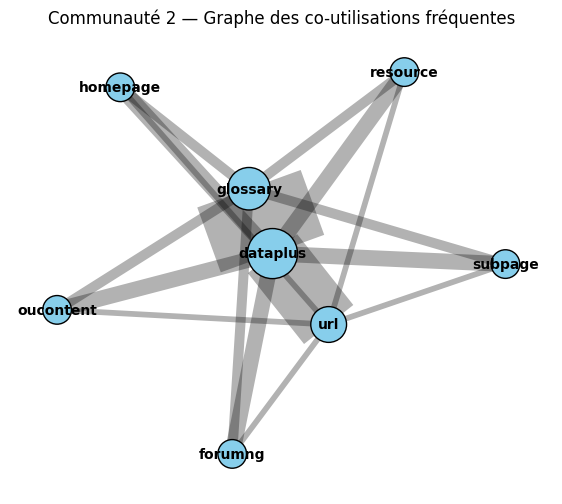

=== Communauté 4 ===


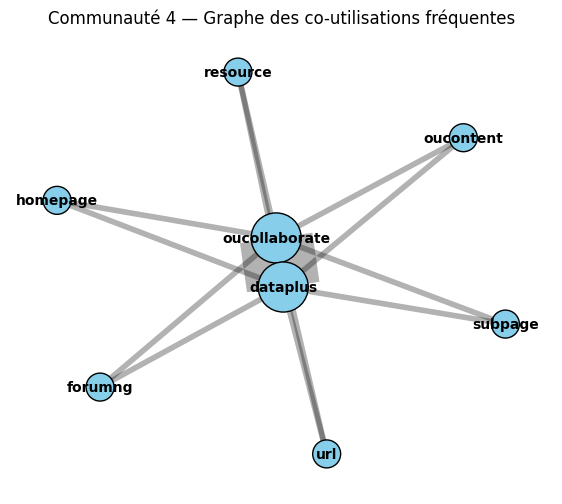

=== Communauté 5 ===


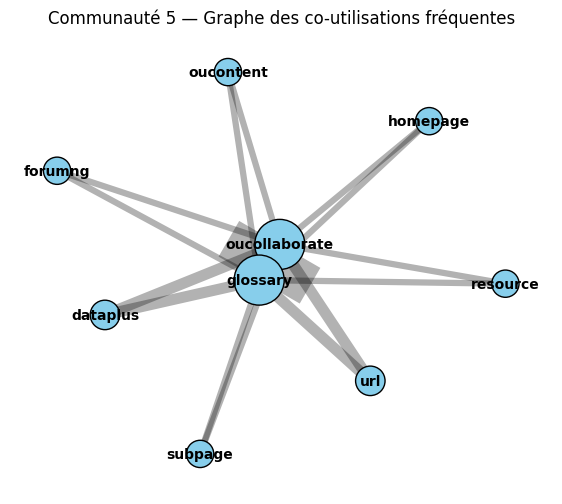

=== Communauté 8 ===


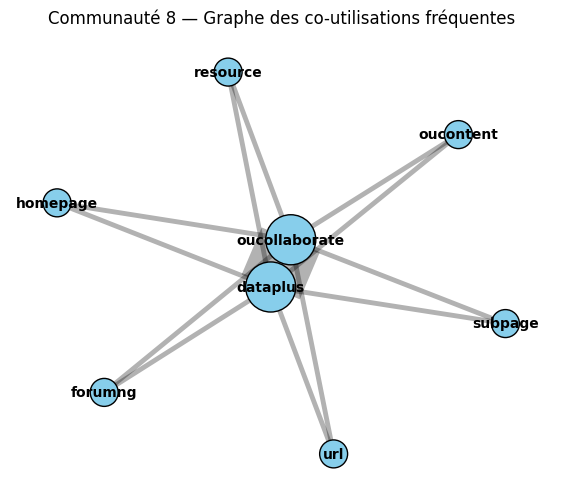

=== Communauté 25 ===


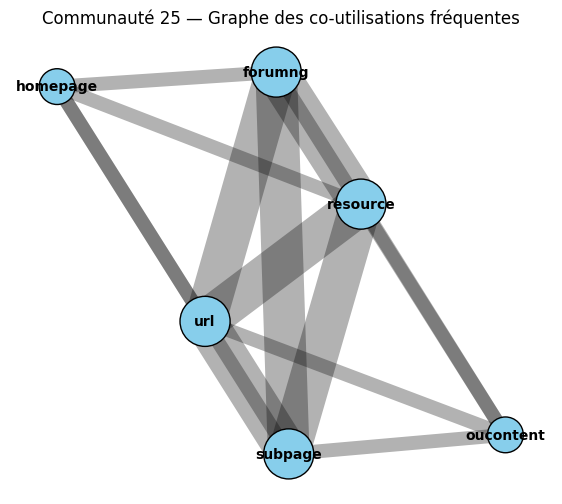

In [ ]:

def plot_rules_network(rules_df, community_id, weight_col="lift", min_lift=1.0):
    """pour aficher le graphe des rrgle d'association pour une communauté qu on veut """
    sub = rules_df[rules_df["community"] == community_id].copy()
    sub = sub[sub[weight_col] >= min_lift]

    if sub.empty:
        print(f"Aucune règle à afficher pour la communauté {community_id}")
        return

    # construction du graphe  du graphe
    G = nx.Graph()
    for _, r in sub.iterrows():
        ants = list(r["antecedents"]) if isinstance(r["antecedents"], (set, frozenset)) else eval(r["antecedents"])
        cons = list(r["consequents"]) if isinstance(r["consequents"], (set, frozenset)) else eval(r["consequents"])
        for a in ants:
            for c in cons:
                if a != c:
                    w = r[weight_col]
                    if G.has_edge(a, c):
                        G[a][c]["weight"] += w
                    else:
                        G.add_edge(a, c, weight=w)

    # taille et couleur selon centralité
    pos = nx.spring_layout(G, seed=42)
    weights = [G[u][v]["weight"] for u,v in G.edges()]
    deg = dict(G.degree(weight="weight"))
    node_sizes = [300 + 1000*(deg[n]/max(deg.values())) for n in G.nodes()]

    plt.figure(figsize=(7,6))
    nx.draw_networkx_edges(G, pos, width=[w*1.5 for w in weights], alpha=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    plt.title(f"Communauté {community_id} — Graphe des co-utilisations fréquentes")
    plt.axis("off")
    plt.show()

for c in sorted(rules_all["community"].unique()):
    print(f"=== Communauté {c} ===")
    plot_rules_network(rules_all, c, min_lift=1.0)

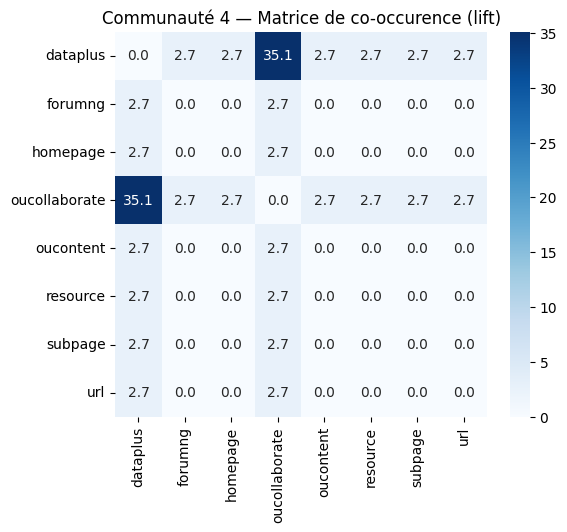

In [ ]:

def plot_cooccurrence_heatmap(rules_df, community_id):
    sub = rules_df[rules_df["community"] == community_id]
    if sub.empty:
        print(f"Aucune règle pour la communauté {community_id}")
        return
    
    # construire matrice de co-occurence pondérée par lift
    types = sorted(set().union(*sub["antecedents"], *sub["consequents"]))
    cooc = pd.DataFrame(0.0, index=types, columns=types)
    for _, r in sub.iterrows():
        ants = list(r["antecedents"]) if isinstance(r["antecedents"], (set, frozenset)) else eval(r["antecedents"])
        cons = list(r["consequents"]) if isinstance(r["consequents"], (set, frozenset)) else eval(r["consequents"])
        for a in ants:
            for c in cons:
                cooc.loc[a,c] += r["lift"]
                cooc.loc[c,a] += r["lift"]
    plt.figure(figsize=(6,5))
    sns.heatmap(cooc, annot=True, fmt=".1f", cmap="Blues")
    plt.title(f"Communauté {community_id} — Matrice de co-occurence (lift)")
    plt.show()

plot_cooccurrence_heatmap(rules_all, 4)


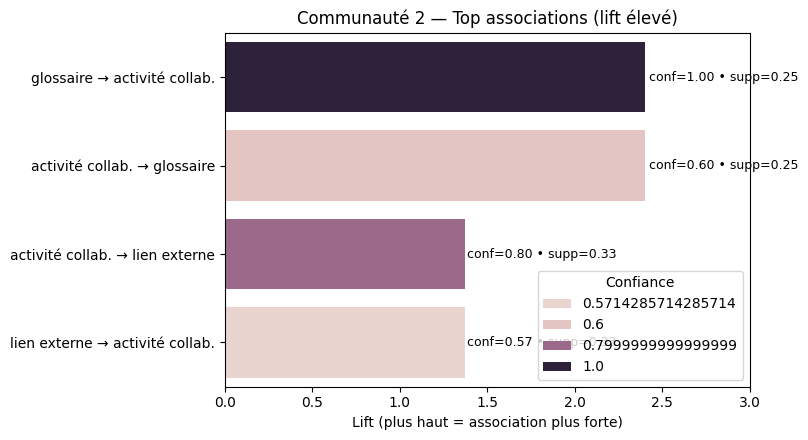

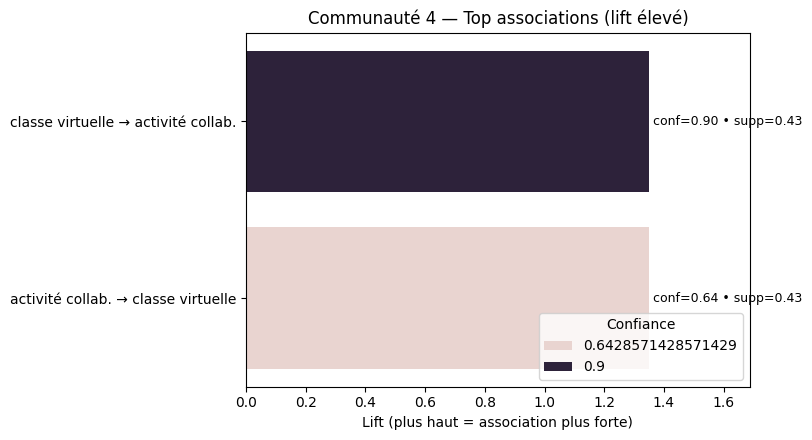

In [ ]:

# 1) On ne garde que les règles où antecedents et consequents sont de taille 1
def rules_to_pairs(rules_df):
    rows = []
    for _, r in rules_df.iterrows():
        ants = r["antecedents"] if isinstance(r["antecedents"], (set, frozenset)) else eval(r["antecedents"])
        cons = r["consequents"] if isinstance(r["consequents"], (set, frozenset)) else eval(r["consequents"])
        if len(ants)==1 and len(cons)==1:
            a = list(ants)[0]; c = list(cons)[0]
            rows.append({
                "community": r["community"],
                "a": a, "b": c,
                "support": r["support"],
                "confidence": r["confidence"],
                "lift": r["lift"]
            })
    return pd.DataFrame(rows)

pairs = rules_to_pairs(rules_all)

name_map = {
    "forumng": "forum",
    "oucollaborate": "classe virtuelle",
    "oucontent": "contenu cours",
    "resource": "ressource",
    "dataplus": "activité collab.",
    "glossary": "glossaire",
    "subpage": "sous-page",
    "homepage": "accueil",
    "url": "lien externe",
}
pairs["a"] = pairs["a"].map(name_map).fillna(pairs["a"])
pairs["b"] = pairs["b"].map(name_map).fillna(pairs["b"])

def plot_top_pairs(comm_id, topk=8, min_support=0.15):
    """Plot des top-k paires par lift avec support"""
    sub = pairs[pairs["community"]==comm_id].copy()
    if sub.empty:
        print(f"Aucune paire pour la communauté {comm_id}")
        return
    sub = sub[sub["support"] >= min_support]
    if sub.empty:
        print(f"Aucune paire avec support ≥ {min_support:.2f} pour C{comm_id}")
        return
    sub["pair"] = sub["a"] + " → " + sub["b"]
    sub = sub.sort_values(["lift","confidence","support"], ascending=False).head(topk)

    plt.figure(figsize=(8,4.5))
    ax = sns.barplot(data=sub, x="lift", y="pair", hue="confidence", dodge=False)
    ax.bar_label(ax.containers[0], fmt="") 
    for i, (_, r) in enumerate(sub.iterrows()):
        plt.text(r["lift"]*1.01, i, f"conf={r['confidence']:.2f} • supp={r['support']:.2f}",
                 va="center", fontsize=9)
    plt.title(f"Communauté {comm_id} — Top associations (lift élevé)")
    plt.xlabel("Lift (plus haut = association plus forte)"); plt.ylabel("")
    plt.legend(title="Confiance", loc="lower right")
    plt.xlim(0, sub["lift"].max()*1.25)
    plt.tight_layout()
    plt.show()

plot_top_pairs(2, topk=8, min_support=0.15)
plot_top_pairs(4, topk=8, min_support=0.15)


In [25]:
def auto_sentence(comm_id):
    sub = pairs[pairs["community"]==comm_id].copy()
    if sub.empty:
        return f"C{comm_id}: pas d’association simple détectée."
    s = sub.sort_values(["lift","confidence","support"], ascending=False).head(3)
    items = [f"{row.a} → {row.b} (lift {row.lift:.2f}, conf {row.confidence:.2f})" for _, row in s.iterrows()]
    return f"C{comm_id}: principales co-utilisations : " + "; ".join(items) + "."

for cid in sorted(pairs["community"].unique()):
    print(auto_sentence(cid))

C2: principales co-utilisations : glossaire → activité collab. (lift 2.40, conf 1.00); activité collab. → glossaire (lift 2.40, conf 0.60); activité collab. → lien externe (lift 1.37, conf 0.80).
C4: principales co-utilisations : classe virtuelle → activité collab. (lift 1.35, conf 0.90); activité collab. → classe virtuelle (lift 1.35, conf 0.64).
C5: principales co-utilisations : classe virtuelle → glossaire (lift 1.50, conf 0.80); glossaire → classe virtuelle (lift 1.50, conf 0.50).
C8: principales co-utilisations : classe virtuelle → activité collab. (lift 1.17, conf 0.88); activité collab. → classe virtuelle (lift 1.17, conf 0.58).
C25: principales co-utilisations : forum → ressource (lift 1.11, conf 1.00); ressource → forum (lift 1.11, conf 1.00); forum → sous-page (lift 1.11, conf 1.00).
